Bianca Coen, i6211430  
Emery Karambiri, i6220931  
Ilinca Dumitras, i6252565  


# Data madness 2022

- **Can a model be created to predict an indivuduals risk at heart failure?**
 * How does Linear Regression perform compared to a Random Forest or Logistic Regression?*
- **What are the biggest deciding factors for predicting heart failure?**

1. EDA  
    1.1 Non-continuous features  
    1.2 Continuous features  

2. Prepare dataset  
    2.1. remove errors  
    2.2. OHE  
    2.3. Standardize  
    2.4. Remove outliers  

3. Numerical Analysis  
    3.1 Collinearity  
    3.2 Statistical Difference Test  
        3.2.1. T-test  
        3.2.2. Chi2 test  

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score, train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score, recall_score
from sklearn import tree, metrics

In [2]:
df = pd.read_csv('heart.csv').set_index('HeartDisease').reset_index().rename(columns={'FastingBS':'FastingBS_Above120'})
df.head()

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS_Above120,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,0,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,1,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,0,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HeartDisease        918 non-null    int64  
 1   Age                 918 non-null    int64  
 2   Sex                 918 non-null    object 
 3   ChestPainType       918 non-null    object 
 4   RestingBP           918 non-null    int64  
 5   Cholesterol         918 non-null    int64  
 6   FastingBS_Above120  918 non-null    int64  
 7   RestingECG          918 non-null    object 
 8   MaxHR               918 non-null    int64  
 9   ExerciseAngina      918 non-null    object 
 10  Oldpeak             918 non-null    float64
 11  ST_Slope            918 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
print(df['ST_Slope'].unique())

['Up' 'Flat' 'Down']


# 1. EDA
We have 12 columns in total:
- HeartDisease: Binary. 0 for no heart disease, 1 for heart disease
- Age: Continuous
- Sex: Categorical. M for male, F for female     
- ChestPainType: Categorical. ATA, NAP, ASY or TA
- RestingBP: Continuous
- Cholesterol: Continous   
- FastingBS_Above120: Binary. 0 if fasting blood sugar below 120mg/dl, else 1 
- RestingECG: Categorical. Normal, ST or LVH
- MaxHR: Continuous
- ExerciseAngina: Binary. N if no angina induced by exercise, else Y 
- Oldpeak: Continous
- ST_Slope: Categorical. Up, Flat or Down

### 1.1. Non-continuous features:

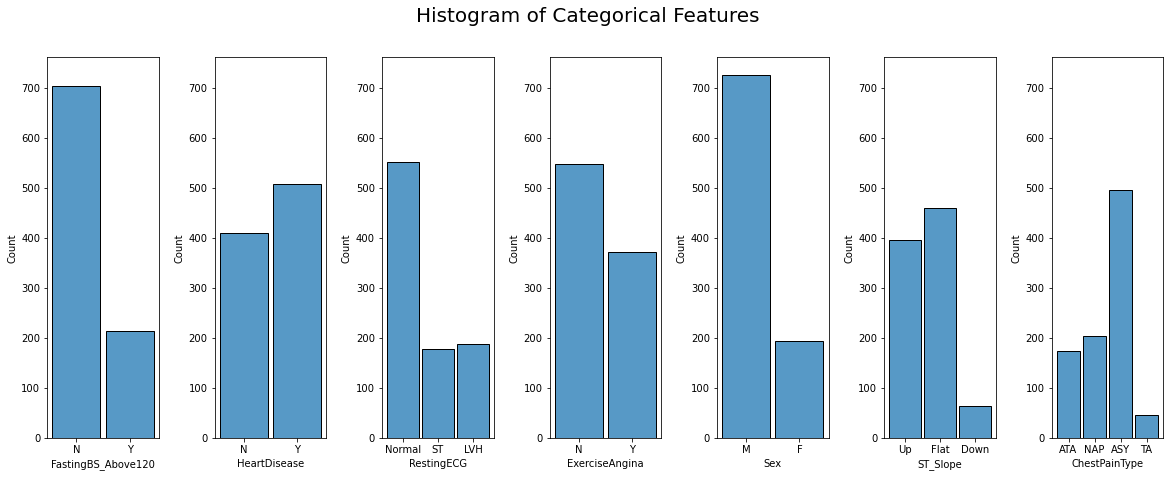

In [5]:
def histogram(data, columns, equal_scales=True, title='Histogram'):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    y_lim =  data[columns].apply(pd.value_counts).max().max()*1.05
    i = 0
    for col in columns:
        g = sns.histplot(data=data, x=col, ax=axs[i], multiple='dodge', shrink=0.9)
        i+=1
        if(equal_scales):
            g.set(ylim=(0,y_lim))
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

# Categorical columns (non-numeric OR only 2 values)
ohe_cols = (df.dtypes=='object')
ohe_cols = ohe_cols[ohe_cols].index.tolist()
bin_cols = (df.nunique()==2)
bin_cols = bin_cols[bin_cols].index.tolist()
histogram(df.replace({0: 'N', 1:'Y'}), set(ohe_cols+bin_cols), title='Histogram of Categorical Features')

We have more or less the same amount of HeartDisease and non-HeartDisease data points in this dataset. Great news!  
However we can see imbalances such as sex and FastingBS_above120 who are clearly imbalanced.

Certain others seem somewhat imbalaced:
- RestingECG (Normal > ST + LVH)
- ST_Slope (Down largly under-represented)
- ChestPainType (TA largly under-represented)

To work around the imbalaces, we will be using K-Fold cross validation. This would increase variability in the data points selected.  
Other options would to create a separate dataset where we undersample the over-represented classes and oversample the under-represented ones.

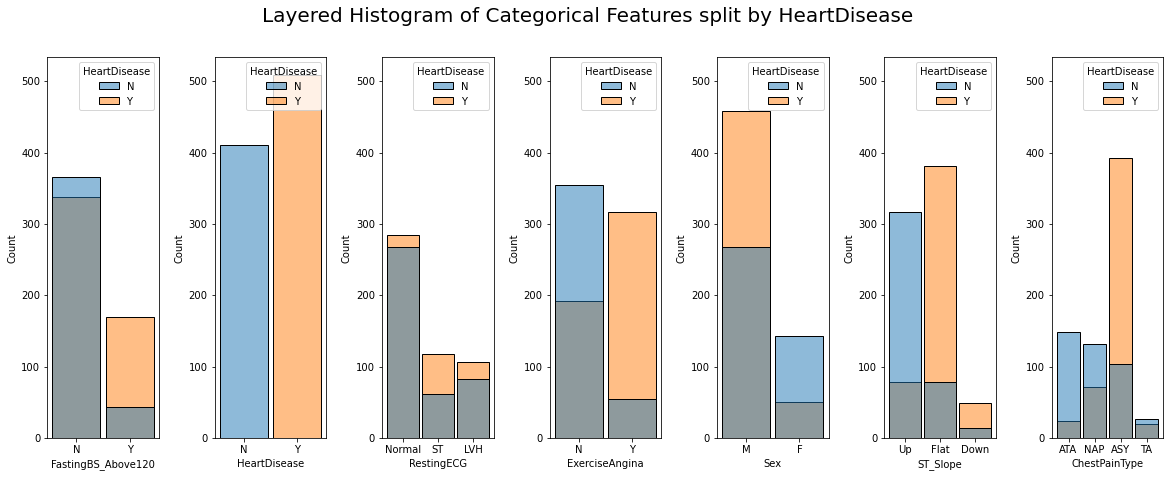

In [6]:
def separate_histogram(data, columns, equal_scales=True, title='Layered Histogram split by HeartDisease', kde=False):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    y_lim = 0
    for val in data['HeartDisease'].unique():
        y_lim = max(y_lim, data[data['HeartDisease']==val][columns].apply(pd.value_counts).max().max()) * 1.05
    i = 0
    for col in columns:
        g = sns.histplot(data=data, x=col, ax=axs[i], hue='HeartDisease', multiple='layer', shrink=0.9, kde=kde, line_kws={'lw': 4})
        i+=1
        if(equal_scales):
            g.set(ylim=(0,y_lim))
        
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

separate_histogram(df.replace({0: 'N', 1:'Y'}), list(set(ohe_cols+bin_cols)), title='Layered Histogram of Categorical Features split by HeartDisease')

In the layered histogram we can see that certain classes, such as a ChestPainType of ASY or an ST_Slope of Flat has a way higher frequency of having heart disease than not. And visa-versa for an ST_Slope of Up for example. This could mean that these variables are important factors when it comes to prediciting heart failure.
### 1.2. Continuous Features

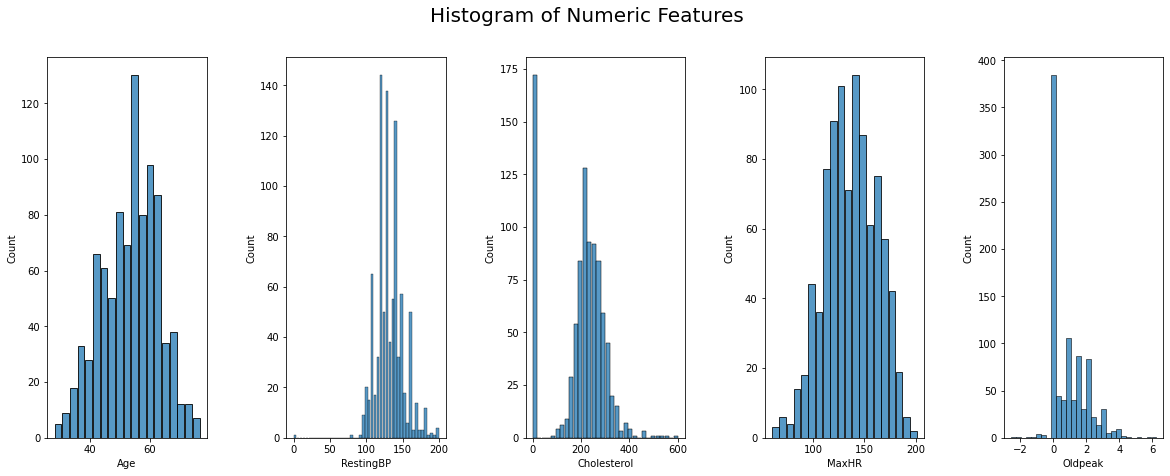

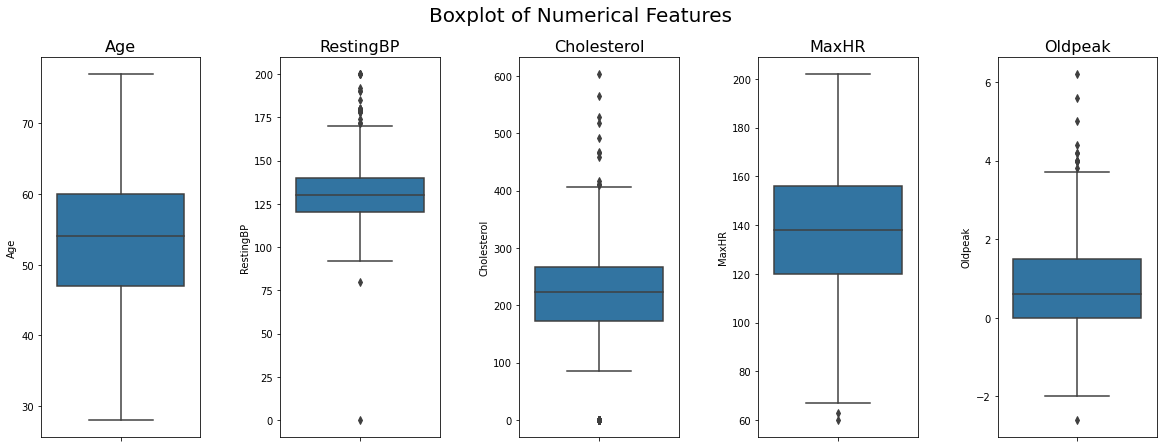

In [7]:
def boxplot(data, columns,  title='Boxplot of Numerical Features'):

    fig, axs = plt.subplots(1, len(selection), figsize=(20, 7))
    i=0
    for col in columns:
        g= sns.boxplot(data=data, y=col, ax=axs[i])
        axs[i].set_title(col, fontsize=16)
        i+=1
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

non_bin =df.drop(columns=ohe_cols+bin_cols+['HeartDisease'])
selection = non_bin.columns.tolist()
histogram(df, selection, equal_scales=False, title='Histogram of Numeric Features')
boxplot(df, selection)

We can see that the continuous variables are more or less normally distributed. Howevever we also see big spikes at 0 for both Cholesterol and Oldpeak. We know that Cholesterol cannot be 0 so these would have to be errors in the data (or the entry would be of a dead person, not very usefull for our model).

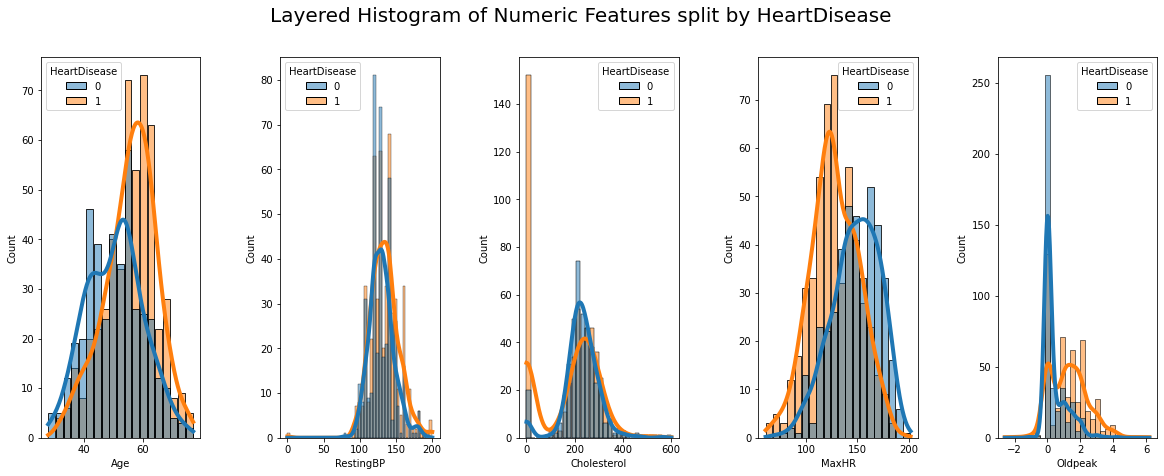

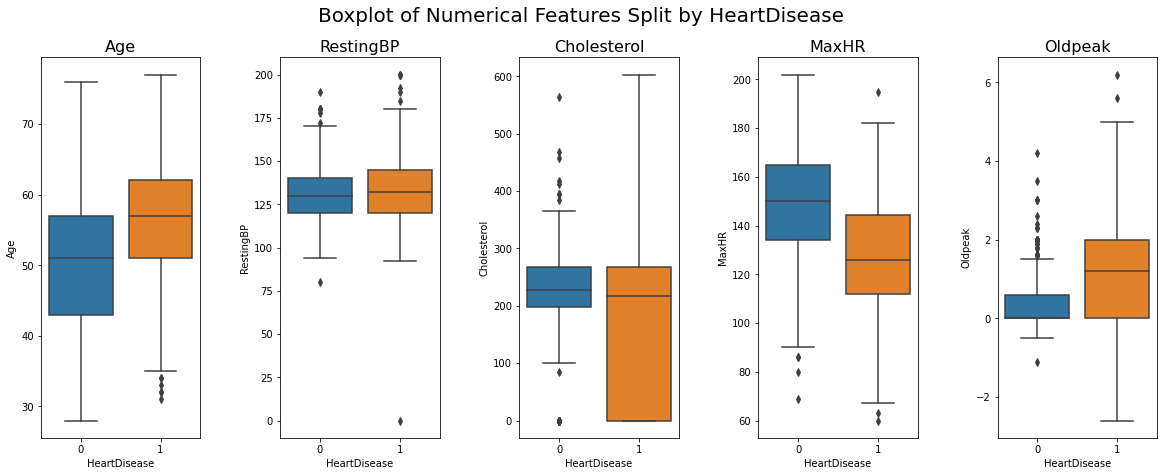

In [8]:
def separate_boxplot(data, columns, title='Boxplot of Numerical Features Split by HeartDisease'):
    fig, axs = plt.subplots(1, len(selection), figsize=(20, 7))
    i=0
    for col in columns:
        g= sns.boxplot(data=data,x='HeartDisease', y=col, ax=axs[i])
        axs[i].set_title(col, fontsize=16)
        i+=1
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

separate_histogram(df, selection, equal_scales=False, kde=True, title = 'Layered Histogram of Numeric Features split by HeartDisease')
separate_boxplot(df, selection)

Here we can see that certain variables have a clear divergences when looking at the groups that have heart disease and those that don't. Such as Age and MaxHR. We can imagine that these would also be important factors.  

Looking at these boxplots we can see that, for certain variables (such as Age and MaxHR as mentioned before), their distribution is different when the entry has heart  disease compared to not. We would have verify that these populations are indeed different with statistical tests such as a T-test.  

*As mentioned above it would seem that the entries with Cholesterol at 0 are those of a deceased person considering the vast majority have(/had) heart disease.*

# 2. Prepare dataset
### 2.1. Remove errors
A person cannot be alive if their cholesteral LDL and/or resting blood pressure are 0.  
   - Cholesteral and RestingBP = 0 is impossible

In [9]:
dropped = df[(df['Cholesterol'] == 0) & (df['Cholesterol'] == 0)]
cleaned = df.drop(dropped.index)
print('Dropped {} rows.\nKept {} rows.'.format(len(dropped), len(cleaned)))

Dropped 172 rows.
Kept 746 rows.


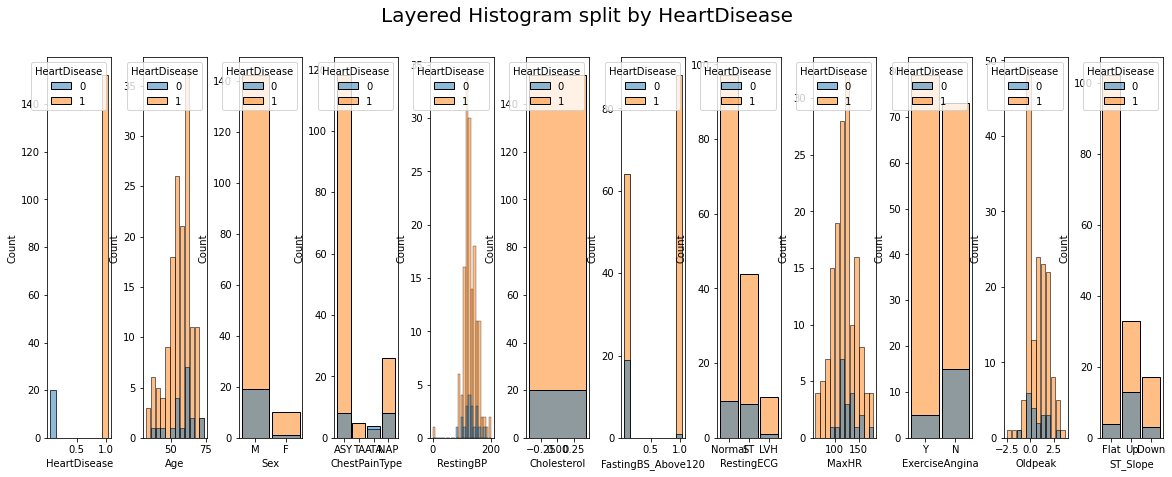

In [10]:
separate_histogram(dropped, dropped.columns, equal_scales=False)

The majority of the dropped rows suffered from heart disease which would make Cholesterol = 0 a good predictor for heart disease however predicting it for a deceased person has no use. 
### 2.2. OHE and Binary to (0, 1):
    - Sex (M or F), ExerciseAngine (N or Y), FastingBS_120+ (0 or 1) are binary -> 0, 1
    - ChestPainType, ST_Slope and RestingECG are categorical -> One Hot Encoding
   

In [11]:
prepared = cleaned.copy(deep=True)

bin_cols = ['Sex', 'ExerciseAngina', 'FastingBS_Above120']
prepared[bin_cols] = prepared[bin_cols].replace({'M':0, 'F':1, 'N' : 0, 'Y':1})

ohe_cols = ['ChestPainType','ST_Slope', 'RestingECG']
prepared = pd.get_dummies(prepared, columns=ohe_cols, prefix_sep='__')
prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HeartDisease        746 non-null    int64  
 1   Age                 746 non-null    int64  
 2   Sex                 746 non-null    int64  
 3   RestingBP           746 non-null    int64  
 4   Cholesterol         746 non-null    int64  
 5   FastingBS_Above120  746 non-null    int64  
 6   MaxHR               746 non-null    int64  
 7   ExerciseAngina      746 non-null    int64  
 8   Oldpeak             746 non-null    float64
 9   ChestPainType__ASY  746 non-null    uint8  
 10  ChestPainType__ATA  746 non-null    uint8  
 11  ChestPainType__NAP  746 non-null    uint8  
 12  ChestPainType__TA   746 non-null    uint8  
 13  ST_Slope__Down      746 non-null    uint8  
 14  ST_Slope__Flat      746 non-null    uint8  
 15  ST_Slope__Up        746 non-null    uint8  
 16  RestingE

### 2.3. Standardize continuous columns
    - Age, RestingBP, Cholesterol, MaxHR, OldPeak

In [12]:
continuous_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
prepared[continuous_cols] = StandardScaler().fit_transform(prepared[continuous_cols])

### 2.4. Remove outliers
    Outside of IQR: after standardization, all values under -3 and above 3

In [13]:
to_drop = prepared[~(prepared.abs()<3).all(axis=1)]
prepared = prepared.drop(to_drop.index)
print('Dropped {} rows. Kept {} rows.'.format(len(to_drop), len(prepared)))

Dropped 19 rows. Kept 727 rows.


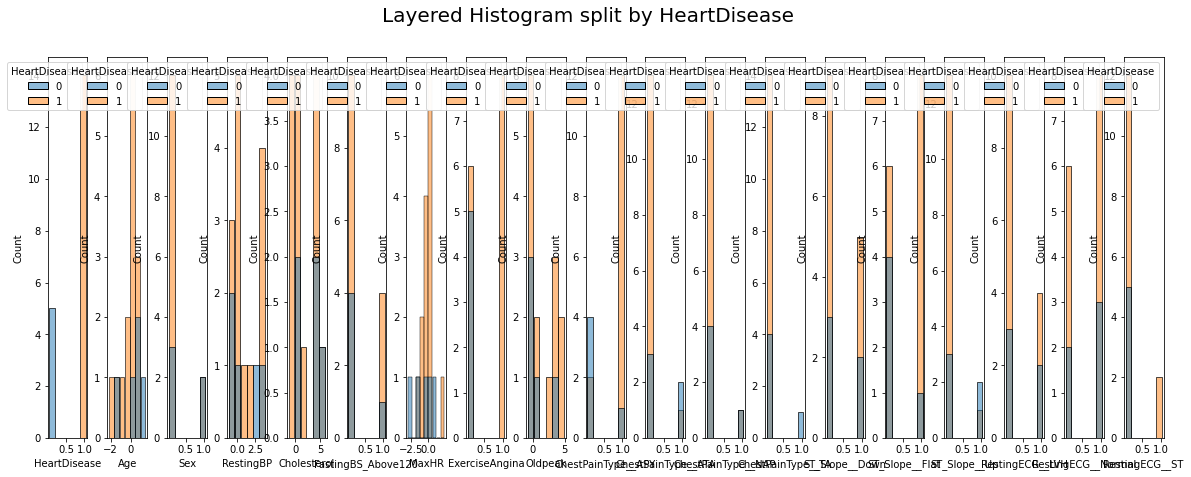

In [14]:
separate_histogram(to_drop, to_drop.columns, equal_scales=False)

Again most of the dropped entries seem to suffer from heart disease. **Dropping them = smart???**
# 3. Numerical Analysis
### 3.1. Collinearity

In [15]:
correlation = prepared.corr()

def correlated(row, threshold):
    cor = row[row.abs()>threshold].index.tolist()
    cor.remove(row.name)
    return cor
correlation['high_cor'] = correlation.apply(correlated, threshold=0.7, axis=1)
correlation['high_cor']

HeartDisease                        []
Age                                 []
Sex                                 []
RestingBP                           []
Cholesterol                         []
FastingBS_Above120                  []
MaxHR                               []
ExerciseAngina                      []
Oldpeak                             []
ChestPainType__ASY                  []
ChestPainType__ATA                  []
ChestPainType__NAP                  []
ChestPainType__TA                   []
ST_Slope__Down                      []
ST_Slope__Flat          [ST_Slope__Up]
ST_Slope__Up          [ST_Slope__Flat]
RestingECG__LVH                     []
RestingECG__Normal                  []
RestingECG__ST                      []
Name: high_cor, dtype: object

Only ST_Slope Up and Flat are highly correlated with eachother. All other features can be used with each other.

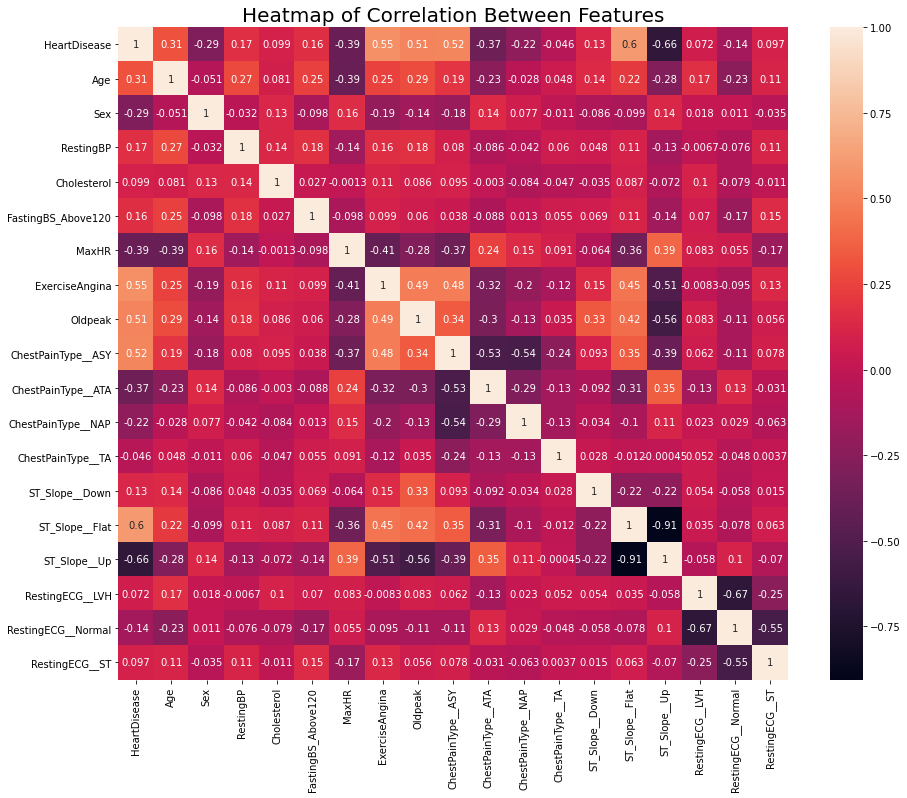

In [16]:
plt.figure(figsize=(15, 12))
sns.heatmap(prepared.corr(),  annot=True)
plt.title('Heatmap of Correlation Between Features', fontsize=20)
plt.show()

The correlation matrix shows us that ST_Slope, ChestPainType, ExerciseAngine and Oldpeak are the variables most correlated to HeartDisease.  

### 3.2. Statistical difference test
#### 3.2.1 2 Tailed T-Test for continuous variables
- For each variable compare the means of the population that suffers from HeartDisease and the population that doesn't.
- $H_{0}$ : $\mu_{i, heartdisease} = \mu_{i, no\_heartdisease}$
- $H_{a}$ : $\mu_{i, heartdisease} \neq \mu_{i, no\_heartdisease}$  
where i $\in$ ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [17]:
significantly_different = set()
non_significantly_different = set()
def ind_t_test(column, group, data):

    group0 = data[data[group]==0][column]
    group1 = data[data[group]==1][column]
    
    print(column,':')
    t_stat, p_val = stats.ttest_ind(group0, group1)
    reject = p_val<significance_level
    print('\t-{} {} vs {} {} => p-value: {:.2E}, t statistic: {:.5f}'.format(group, 0, group, 1, p_val, t_stat))
    if reject:
        print('\t{} significantly different. {:.2E} {} {}. H0 is {}.'.format('', p_val, '<', significance_level, 'rejected'))
    else:
        print('\t{} significantly different. {:.2E} {} {}. H0 is {}.'.format('NOT', p_val, '>', significance_level, 'accepted'))
    print()
    return reject

significance_level = 0.05
for col in continuous_cols:
    if(ind_t_test(col, 'HeartDisease', prepared)):
        significantly_different.add(col)
    else:
        non_significantly_different.add(col)

Age :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.21E-17, t statistic: -8.77492
	 significantly different. 1.21E-17 < 0.05. H0 is rejected.

RestingBP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.54E-06, t statistic: -4.57732
	 significantly different. 5.54E-06 < 0.05. H0 is rejected.

Cholesterol :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 7.55E-03, t statistic: -2.67898
	 significantly different. 7.55E-03 < 0.05. H0 is rejected.

MaxHR :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 4.47E-28, t statistic: 11.46360
	 significantly different. 4.47E-28 < 0.05. H0 is rejected.

Oldpeak :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.02E-49, t statistic: -16.02808
	 significantly different. 1.02E-49 < 0.05. H0 is rejected.



#### 3.2.2 Chi-Squared tests for binary variables
- For each variable compare the proportions of the population that suffers from HeartDisease and the population that doesn't.
- $H_0$: variable is indepent to HeartDisease
- $H_a$: variable is depent to HeartDisease  
where i $\in$ ['Sex', 'FastingBS_120+', 'ExerciseAngina', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST']


In [18]:
def ind_chi2_test(column, group, data):
    contigency = pd.crosstab(data[col], data[group])
    chi2, p_val, dof, expected = stats.chi2_contingency(contigency) 
    reject = p_val<significance_level
    
    print(column,':')
    print('\t-{} {} vs {} {} => p-value: {:.2E}, Chi-Square value: {:.5f}'.format(group, data[group].unique()[0], group, data[group].unique()[1], p_val, chi2))
    if reject:
        print('\t{} significantly different. {:.2E} {} {}. H0 is {}.'.format('',p_val, '<', significance_level, 'rejected'))
    else:
        print('\t{} significantly different. {:.2E} {} {}. H0 is {}.'.format('NOT',p_val, '>', significance_level, 'accepted'))
    print()
    return reject

significance_level = 0.05
for col in prepared.drop(columns=continuous_cols+['HeartDisease']):
    if(ind_chi2_test(col, 'HeartDisease', prepared)):
        significantly_different.add(col)
    else:
        non_significantly_different.add(col)

Sex :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.41E-15, Chi-Square value: 61.10694
	 significantly different. 5.41E-15 < 0.05. H0 is rejected.

FastingBS_Above120 :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 2.52E-05, Chi-Square value: 17.75017
	 significantly different. 2.52E-05 < 0.05. H0 is rejected.

ExerciseAngina :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.02E-50, Chi-Square value: 220.81197
	 significantly different. 6.02E-50 < 0.05. H0 is rejected.

ChestPainType__ASY :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.82E-44, Chi-Square value: 193.37761
	 significantly different. 5.82E-44 < 0.05. H0 is rejected.

ChestPainType__ATA :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.39E-23, Chi-Square value: 100.18565
	 significantly different. 1.39E-23 < 0.05. H0 is rejected.

ChestPainType__NAP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.22E-09, Chi-Square value: 34.10746
	 significantly different. 5.22E-09 < 0.05. H0 is rejected.

ChestPainType__TA :


In [19]:
non_significantly_different = list(non_significantly_different)
non_significantly_different.sort()

significantly_different = list(significantly_different)
significantly_different.sort()
print('No statistically significant difference:\n\t-',non_significantly_different)
print('\nStatistically significant difference:\n\t-',significantly_different)

No statistically significant difference:
	- ['ChestPainType__TA', 'RestingECG__LVH']

Statistically significant difference:
	- ['Age', 'ChestPainType__ASY', 'ChestPainType__ATA', 'ChestPainType__NAP', 'Cholesterol', 'ExerciseAngina', 'FastingBS_Above120', 'MaxHR', 'Oldpeak', 'RestingBP', 'RestingECG__Normal', 'RestingECG__ST', 'ST_Slope__Down', 'ST_Slope__Flat', 'ST_Slope__Up', 'Sex']


A ChestPainType of TA and a RestingECG of LVH seem to have no effect on predicting HeartDisease, however all other variables could be used in order to try and predict HeartDisease.  